In [ ]:
import tensorflow as tf
from tensorflow.python.util import dispatch
from typing import Union
import random
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)


class AbftTensor(tf.experimental.BatchableExtensionType):
  # __name__ is required for serialization in SavedModel; see below for details.
  __name__ = 'extension_type_colab.AbftTensor'

  values: tf.Tensor

  shape = property(lambda self: self.values.shape)
  def set_shape(self, value):
        print(f"Setting shape {value} from {self.values.shape}")
        self.values.set_shape = value

  dtype = property(lambda self: self.values.dtype)

  def __init__(self, values):
      self.values = values

  def __len__(self):
    return len(self.values)

  def row_checksum(self):
    # print(f"Row: {self.row_checksum.shape}")
    return tf.math.reduce_sum(self.values, 0, keepdims=1)

  def col_checksum(self):
    # print(f"Col: {self.col_checksum.shape}")
    return tf.math.reduce_sum(self.values, 1, keepdims=1)

  def __getitem__(self, item):
    return AbftTensor(self.values[item])
    [item]
  # def __validate__(self):
  #   assert tf.math.reduce_all(self.checksum == tf.math.reduce_sum(self.values, range(1, len(self.values.shape)))), 'Checksum failed!'

  # def with_default(self, default):
  #   return tf.where(self.checksum, self.values, default)

  # def __repr__(self):
  #   return abft_tensor_str(self.values, self.checksum)

  class Spec:
    def __init__(self, shape, dtype=tf.float32):
      self.values = tf.TensorSpec(shape, dtype)
      # self.row_checksum = tf.TensorSpec((1,shape[1],), dtype)
      # self.col_checksum = tf.TensorSpec((shape[0],1), dtype)

    shape = property(lambda self: self.values.shape)
    dtype = property(lambda self: self.values.dtype)



def convert_to_abft_tensor(x):
  if isinstance(x, AbftTensor):
    return x
  else:
    return AbftTensor(x)



@tf.experimental.dispatch_for_unary_elementwise_apis(AbftTensor)
def unary_elementwise_op_handler(op, x):
 return AbftTensor(op(x.values))

@tf.experimental.dispatch_for_binary_elementwise_apis(
    Union[AbftTensor, tf.Tensor],
    Union[AbftTensor, tf.Tensor])
def binary_elementwise_op_handler(op, x, y):
  x = convert_to_abft_tensor(x)
  y = convert_to_abft_tensor(y)
  return AbftTensor(op(x.values, y.values))

from TensorFI2.src import tensorfi2 as tfi


abft_inject_faults: bool = False
abft_detect_faults: bool = False
abft_throw_faults: bool = False


@tf.experimental.dispatch_for_api(tf.matmul)
def abft_matmul(a: AbftTensor, b,
                  transpose_a=False, transpose_b=False,
                  adjoint_a=False, adjoint_b=False,
                  a_is_sparse=False, b_is_sparse=False,
                  output_type=None):
  # print(f"mult  a:{a.shape} b:{b.shape}")
  if isinstance(b, AbftTensor):
    b_abft = b
    b = b.values
  c = AbftTensor(tf.matmul(a.values, b, transpose_a, transpose_b, adjoint_a,
                  adjoint_b, a_is_sparse, b_is_sparse, output_type))
  if tf.executing_eagerly() and abft_inject_faults:
    # print("Injecting!")
    flip_r = random.randint(0, c.shape[0]-1)
    flip_c = random.randint(0, c.shape[1]-1)

    pos = random.randint(0, 31)
    indices = [[flip_r, flip_c]]  
    values = [tfi.bitflip(c.values[flip_r][flip_c], pos)]
    delta = tf.SparseTensor(indices, values, c.shape)
    result = c.values + tf.sparse.to_dense(delta)
    c = AbftTensor(result)

  # print(f"Checksum S_a{a.row_checksum().shape} B: {b.shape}")
  if abft_detect_faults:
    s_ab = tf.matmul(a.row_checksum(), b)
    # ab_s = tf.matmul(a.values, b.checksum)
    c_rows_sum = tf.reduce_sum(c.values,0, keepdims=1)
    # print(f"s_ab: {s_ab}")
    # print(f"c_rows_sum: {c_rows_sum}")
    if tf.executing_eagerly():
      no_fault_detected = tf.experimental.numpy.allclose(s_ab,c_rows_sum, atol=1e-04)
      if abft_throw_faults:
        assert no_fault_detected, f"Abft failure! {s_ab} != {c_rows_sum}"
    # else:
    #   print("No checksum since delayed.")
  return c
  
@tf.experimental.dispatch_for_api(tf.tensordot)
def abft_tensordot(a: AbftTensor, b, axes, name=None):
  # print(f"dot {a.shape}{b.shape}")
  if isinstance(a, AbftTensor):
    a = a.values
  if isinstance(a, AbftTensor):
    b = b.values
  return AbftTensor(tf.tensordot(a, b, axes, name))

@tf.experimental.dispatch_for_api(tf.convert_to_tensor)
def abft_convert_to_tensor(value: AbftTensor, dtype=None, dtype_hint=None, name=None):
  # print("Convert")
  if isinstance(value, AbftTensor):
    return tf.convert_to_tensor(value.values, dtype, dtype_hint, name)
  else:
    return tf.convert_to_tensor(value, dtype, dtype_hint, name)


from tensorflow.python.framework import ops

from tensorflow.python.framework import tensor_conversion_registry

def conversion_func(value, dtype=None, name=None, as_ref=False):
  return ops.convert_to_tensor(value.values, dtype, name,as_ref)

tf.register_tensor_conversion_function(
    AbftTensor, conversion_func, priority=100
)


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import random
import keras
import time


def do_boston(fault_injection: bool, abft: bool, epochs: int = 10, throw_abft_error = False,verbose = True):
  print(f"Training and Executing Boston Fault Injection:{fault_injection} ABFT: {abft}")
  global abft_inject_faults
  abft_inject_faults = fault_injection
  global abft_detect_faults
  abft_detect_faults = abft
  global abft_throw_faults
  abft_throw_faults = throw_abft_error


  import os
  os.environ['PYTHONHASHSEED']=str(66)

  import random
  random.seed(66)

  np.random.seed(66)
  tf.random.set_seed(66)

  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  

  (x_train, y_train), (x_test, y_test) = datasets.boston_housing.load_data()
  train_mean = np.mean(x_train, axis=0)
  train_std = np.std(x_train, axis=0)
  train_features = (x_train - train_mean) / train_std
  test_features_norm = (x_test - train_mean) / train_std



  if abft or fault_injection:
    def abft_relu(x):
      return AbftTensor(keras.activations.relu(x))
    class abft_glorot_uniform(keras.initializers.glorot_uniform):
      def __call__(self, shape, dtype=None, **kwargs):
        return AbftTensor(super(abft_glorot_uniform, self).__call__(shape, dtype, **kwargs))

    input_spec = AbftTensor.Spec(train_features.shape, tf.float32)
    x_train = AbftTensor(x_train)
    train_features = AbftTensor(train_features)
    test_features_norm = AbftTensor(test_features_norm)
    relu_func = abft_relu
    init_class = abft_glorot_uniform
  else:
    input_spec = tf.TensorSpec(train_features.shape, tf.float32)
    relu_func = keras.activations.relu
    init_class = keras.initializers.glorot_uniform



  boston_model = models.Sequential()
  boston_model.add(layers.InputLayer(type_spec=input_spec))
  boston_model.add(layers.Dense(20,activation=relu_func, kernel_initializer=init_class(seed=66)))
  boston_model.add(layers.Dense(1,activation=relu_func, kernel_initializer=init_class(seed=66)))

  # boston_model.summary()

  boston_model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae', 'mse'], run_eagerly=True)

  start=time.time()
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
  history = boston_model.fit(train_features, y_train, epochs=epochs, verbose=verbose, validation_data=(test_features_norm,y_test), shuffle=False,
                      callbacks=[early_stop])
  end=time.time()
  rmse_final = np.sqrt(float(history.history['val_mse'][-1]))
  print(f"RMSE Error: {rmse_final}")
  print("training_time:",end-start)
  return (end-start), rmse_final

print("Executing test cases")
training_epochs = 5
_,sdc_1 = do_boston(False, False, training_epochs)
_,sdc_2 = do_boston(False, False, training_epochs)
assert sdc_1 == sdc_2, "RMS should be same due to deterministic behaviour" 

_,sdc_abft = do_boston(False, True, training_epochs, False)
assert sdc_1 == sdc_abft, f"RMS should be same due to deterministic behaviour {sdc_1} {sdc_abft}" 

_,sdc_fi = do_boston(True, False, training_epochs)
import math
assert sdc_1 < sdc_fi or math.isnan(sdc_fi), "FI RMS should be more! {sdc_1} < {sdc_fi}" 

try:
  _,sdc_fi_abft = do_boston(True, True, training_epochs, True)
  raise RuntimeError("Should not reach here.  ABFT should have detected a fault")
except AssertionError as ae:
  print(f"Successfully caught assertion error {ae}")

_,sdc_fi_abft = do_boston(True, True, training_epochs, False)
assert sdc_1 < sdc_fi_abft or math.isnan(sdc_fi_abft), "FI RMS should be more! {sdc_1} < {sdc_fi_abft}" 





Executing test cases
Training and Executing Boston Fault Injection:False ABFT: False
Epoch 1/5
13/13 [==============================] - 1s 26ms/step - loss: 575.3324 - mae: 22.1941 - mse: 575.3324 - val_loss: 598.6422 - val_mae: 22.7482 - val_mse: 598.6422
Epoch 2/5
13/13 [==============================] - 0s 20ms/step - loss: 568.4198 - mae: 22.0662 - mse: 568.4198 - val_loss: 589.6136 - val_mae: 22.5767 - val_mse: 589.6136
Epoch 3/5
13/13 [==============================] - 0s 21ms/step - loss: 558.8830 - mae: 21.8850 - mse: 558.8830 - val_loss: 578.3877 - val_mae: 22.3618 - val_mse: 578.3877
Epoch 4/5
13/13 [==============================] - 0s 22ms/step - loss: 548.1387 - mae: 21.6771 - mse: 548.1387 - val_loss: 566.4680 - val_mae: 22.1304 - val_mse: 566.4680
Epoch 5/5
13/13 [==============================] - 0s 23ms/step - loss: 536.7958 - mae: 21.4550 - mse: 536.7958 - val_loss: 553.9682 - val_mae: 21.8857 - val_mse: 553.9682
RMSE Error: 23.53652907043844
training_time: 1.95038294

In [ ]:
training_time=[]
sdc_percentage=[]

training_epochs = 50
train,sdc_1 = do_boston(False, False, training_epochs, False, False)

training_time.append(train)
sdc_percentage.append(sdc_1)

train,sdc_abft = do_boston(False, True, training_epochs, False, False)
training_time.append(train)
sdc_percentage.append(sdc_abft)

Training and Executing Boston Fault Injection:False ABFT: False
RMSE Error: 8.712405723379137
training_time: 11.8464515209198
Training and Executing Boston Fault Injection:False ABFT: True
RMSE Error: 8.712405723379137
training_time: 12.733981847763062


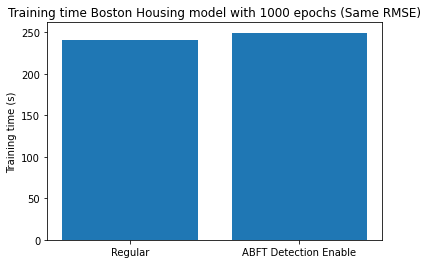

Overhead: 0.03421800676641551%


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
# fig, ax = plt.subplots()
tensor_models = ['Regular','ABFT Detection Enable']
# ax.bar(tensor_models,[sdc_percentage[0],sdc_percentage[1]])
# ax.set_title('RMSE rate on Boston Housing model')
# ax.set_xticks(x, models)

# plt.show()

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.bar(tensor_models,[training_time[0],training_time[1]])
ax.set_ylabel('Training time (s)')
ax.set_title(f"Training time Boston Housing model with {training_epochs} epochs (Same RMSE)")
# ax.set_xticks(x, models)

plt.show()
print(f"Overhead: {(1.0 - training_time[0]/training_time[1])}%")